In [1]:
# standard library imports
from __future__ import absolute_import, division, print_function

import numpy as np
from matplotlib import pyplot as plt
from matplotlib.font_manager import FontProperties
from scipy.signal import argrelmin, argrelmax
import scipy as sp

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras.utils import to_categorical
from keras import Sequential
from keras.layers import Lambda, Dense, Input, Layer, Dropout
from keras.models import Model
from keras.utils import to_categorical
from keras.callbacks import LambdaCallback, EarlyStopping
import keras.backend as K
import keras

import inspect

Using TensorFlow backend.


In [2]:
# Global plot settings
from matplotlib import rc
import matplotlib.font_manager
from matplotlib.font_manager import FontProperties

rc('font', family='serif')
rc('text', usetex=True)
rc('font', size=22)
rc('xtick', labelsize=15)
rc('ytick', labelsize=15)
rc('legend', fontsize=15)

fontP = FontProperties()
fontP.set_size(10)

In [3]:
#Check Versions
print(tf.__version__)  #1.15.0
print(keras.__version__)  #2.2.4

1.15.0
2.2.4


# Alternative DCTR fitting algorithm

The DCTR paper (https://arxiv.org/abs/1907.08209) shows how a continuously parameterized NN used for reweighting:

$f(x,\theta)=\text{argmax}_{f'}(\sum_{i\in\bf{\theta}_0}\log f'(x_i,\theta)+\sum_{i\in\bf{\theta}}\log (1-f'(x_i,\theta)))$

can also be used for fitting:

$\theta^*=\text{argmax}_{\theta'}(\sum_{i\in\bf{\theta}_0}\log f(x_i,\theta')+\sum_{i\in\bf{\theta}}\log (1-f(x_i,\theta')))$

This works well when the reweighting and fitting happen on the same 'level'.  However, if the reweighting happens at truth level (before detector simulation) while the fit happens in data (after the effects of the detector), this procedure will not work.  It works only if the reweighting and fitting both happen at detector-level or both happen at truth-level.  This notebook illustrates an alternative procedure:

$\theta^*=\text{argmax}_{\theta'}\text{min}_{g}(-\sum_{i\in\bf{\theta}_0}\log g(x_i)-\sum_{i\in\bf{\theta}}(f(x_i,\theta')/(1-f(x_i,\theta')))\log (1-g(x_i)))$

where the $f(x,\theta')/(1-f(x,\theta'))$ is the reweighting function.  The intuition of the above equation is that the classifier $g$ is trying to distinguish the two samples and we try to find a $\theta$ that makes $g$'s task maximally hard.  If $g$ can't tell apart the two samples, then the reweighting has worked!  This is similar to the minimax graining of a GAN, only now the analog of the generator network is the reweighting network which is fixed and thus the only trainable parameters are the $\theta'$.  The advantage of this second approach is that it readily generalizes to the case where the reweighting happens on a different level:

$\theta^*=\text{argmax}_{\theta'}\text{min}_{g}(-\sum_{i\in\bf{\theta}_0}\log g(x_{D,i})-\sum_{i\in\bf{\theta}}\frac{f(x_{T,i},\theta')}{1-f(x_{T,i},\theta')}\log (1-g(x_{D,i})))$

where $x_T$ is the truth value and $x_D$ is the detector-level value.  In simulation (the second sum), these come in pairs and so one can apply the reweighting on one level and the classification on the other.  Asympotitically, both this method and the one in the body of the DCTR paper learn the same result: $\theta^*=\theta_0$.

# Training a DCTR Model

First, we need to train a DCTR model to provide us with a reweighting function to be used during fitting.
This is taken directly from the original Gaussian Notebook.

We will now parametrize our network by giving it $\mu$ and $\sigma$ values in addition to $X_i\sim\mathcal{N}(\mu, \sigma)$.

First we uniformly sample $\mu$ and $\sigma$ values in some range

In [4]:
mu_min = -2
mu_max = 2

sigma_min = 0.5
sigma_max = 4.5

We then sample from normal distributions with these $\mu$ and $\sigma$ values.

Please note that the samples in X0 are not paired with $\mu=0, \sigma = 1$ as this would make the task trivial. 

Instead it is paired with the $\mu, \sigma$ values uniformly sampled in the specified range [$\mu_{min}, \mu_{max}$] and [$\sigma_{min}, \sigma_{max}$].

For every value of $\mu$ in mu_values and every value of $\sigma$ in sigma_values, the network sees one event drawn from $\mathcal{N}(0,1)$ and $\mathcal{N}(\mu,\sigma)$, and it learns to classify them. 

I.e. we have one network that's parametrized by $\mu$ and $\sigma$ that classifies between events from $\mathcal{N}(0,1)$ and $\mathcal{N}(\mu,\sigma)$, and a trained network will give us the likelihood ratio to reweight from one to another. 

## Build and Train DCTR model

In [5]:
# Either load or train DCTR


def get_dctr(load=False,
             n_data_points=10**7,
             mu_min=-2,
             mu_max=2,
             sigma_min=0.5,
             sigma_max=4):
    if load:
        json_file = open('2d_gaussian_dctr_model.json', 'r')
        loaded_model_json = json_file.read()
        json_file.close()
        dctr_model = keras.models.model_from_json(loaded_model_json)
        # load weights into new model
        dctr_model.load_weights("2d_gaussian_dctr_model.h5")
        print("Loaded model from disk")
    else:
        # Generate training & validation data
        mu_values = np.random.uniform(mu_min, mu_max, n_data_points)
        sigma_values = np.random.uniform(sigma_min, sigma_max, n_data_points)

        X0 = [(np.random.normal(0, 1), mu_values[i], sigma_values[i])
              for i in range(n_data_points)]  # Note the zero in normal(0, 1)
        X1 = [(np.random.normal(mu_values[i], sigma_values[i]), mu_values[i],
               sigma_values[i]) for i in range(n_data_points)]

        Y0 = to_categorical(np.zeros(n_data_points), num_classes=2)
        Y1 = to_categorical(np.ones(n_data_points), num_classes=2)

        X = np.concatenate((X0, X1))
        Y = np.concatenate((Y0, Y1))

        X_train, X_test, Y_train, Y_test = train_test_split(X,
                                                            Y,
                                                            test_size=0.5)

        # Build Model
        inputs = Input((3, ))
        hidden_layer_1 = Dense(50, activation='relu')(inputs)
        hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
        hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)
        outputs = Dense(2, activation='softmax')(hidden_layer_3)

        dctr_model = Model(inputs=inputs, outputs=outputs)
        dctr_model.compile(loss='categorical_crossentropy',
                           optimizer='Adam',
                           metrics=['accuracy'])

        # Train Model
        earlystopping = EarlyStopping(patience=10, restore_best_weights=True)
        dctr_model.fit(X_train,
                       Y_train,
                       epochs=200,
                       batch_size=10000,
                       validation_data=(X_test, Y_test),
                       callbacks=[earlystopping],
                       verbose=0)
        print("Trained DCTR Model")

    return dctr_model

### Loading Model

In [6]:
dctr_model = get_dctr()






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where








Trained DCTR Model


### Defining reweighting functions

For a fully trained DCTR $f(x, \theta)$, the reweighting function is: $w(x_{T,i},\theta)=((f(x_{T,i},\theta)/(1-f(x_{T,i},\theta)))$.

Takes observable from simulation ${\bf \theta_0}$ and weights it to observable from data (target) ${\bf \theta_1}$.

The expression for the analytical reweighting function is : $w(x_T, \mu, \sigma) = \frac{\sigma_0}{\sigma}\exp{(-((\frac{x_T-\mu}{\sigma})^2-(\frac{x_T-\mu_0}{\sigma_0})^2)/2)}$.

In [7]:
theta0_param = (0, 1)


# from NN (DCTR)
def reweight(events, param):

    # creating tensor with same length as inputs, with theta_prime in every entry
    concat_input_and_params = K.ones(shape=(events.shape[0], 2)) * param
    # combining and reshaping into correct format:
    model_inputs = K.concatenate((events, concat_input_and_params), axis=-1)
    f = dctr_model(model_inputs)
    weights = (f[:, 1]) / (f[:, 0])
    weights = K.expand_dims(weights, axis=1)
    return weights


# from analytical formula for normal distributions
def analytical_reweight(events, param, param0=theta0_param):
    weights = (param0[1] / param[1]) * K.exp(-0.5 * (
        ((events - param[0]) / param[1])**2 -
        ((events - param0[0]) / param0[1])**2))
    return weights

## Validate DCTR for any $\mu$ and $\sigma$

### Validate for Truth Level

In [8]:
mu1 = 1
sigma1 = 1.5
assert mu1 >= mu_min and mu1 <= mu_max  # choose mu1 in valid range
assert sigma1 >= sigma_min and sigma1 <= sigma_max  # choose mu1 in valid range
X0_val_T = np.random.normal(0, 1, 10**6)
X1_val_T = np.random.normal(mu1, sigma1, 10**6)

In [9]:
weights = reweight(
    K.expand_dims(tf.convert_to_tensor(X0_val_T, dtype=tf.float32)),
    np.array([mu1, sigma1]))
analytical_weights = analytical_reweight(X0_val_T, np.array([mu1, sigma1]))
weights = K.eval(weights)
analytical_weights = K.eval(analytical_weights)

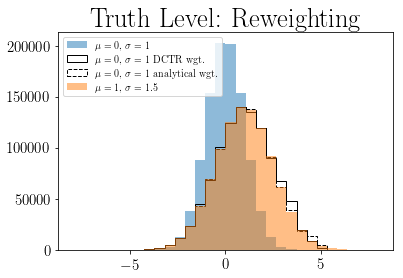

In [10]:
bins = np.linspace(-8, 8, 31)
plt.hist(X0_val_T, bins=bins, alpha=0.5, label=r'$\mu=0$, $\sigma=1$')
plt.hist(X0_val_T,
         bins=bins,
         label=r'$\mu=0$, $\sigma=1$ DCTR wgt.',
         weights=weights,
         histtype='step',
         color='k')
plt.hist(X0_val_T,
         bins=bins,
         label=r'$\mu=0$, $\sigma=1$ analytical wgt.',
         weights=analytical_weights,
         histtype='step',
         linestyle='--',
         color='k')
plt.hist(X1_val_T,
         bins=bins,
         alpha=0.5,
         label=r'$\mu={}$, $\sigma={}$'.format(mu1, sigma1))
plt.legend(prop=fontP, loc='upper left')
plt.title("Truth Level: Reweighting")
#plt.savefig("GaussianAltFit-2D-Truth-Level:Reweighting.png")
plt.show()

### Validate for Detector Level

To apply detector effects, each event $x_{T,i}$in the sample is smeared by shifting by $Z_{i}$ from $Z = \mathcal{N}(0,\epsilon)$,where $\epsilon$ represents the smearing. Thus: $x_{D,i} = x_{T,i} + Z_{i}$

In [11]:
# Generate detector level by smearing truth

epsilon_val = 0.5  #Smearing width

X0_val_D = np.array([(x + np.random.normal(0, epsilon_val))
                     for x in X0_val_T])  #Detector smearing
X1_val_D = np.array([(x + np.random.normal(0, epsilon_val))
                     for x in X1_val_T])  #Detector smearing

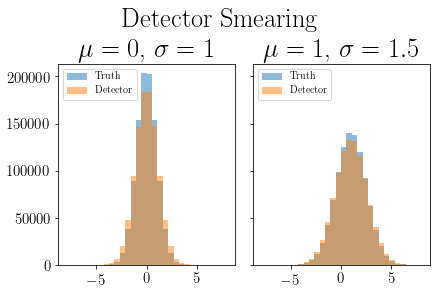

In [12]:
fig, axs = plt.subplots(1, 2, sharey=True, constrained_layout=True)
fig.suptitle('Detector Smearing')
axs[0].set_title('$\mu=0$, $\sigma=1$')
axs[0].hist(X0_val_T, bins=bins, alpha=0.5, label='Truth')
axs[0].hist(X0_val_D, bins=bins, alpha=0.5, label='Detector')
axs[0].legend(prop=fontP, loc='upper left')
axs[1].set_title('$\mu={}$, $\sigma={}$'.format(mu1, sigma1))
axs[1].hist(X1_val_T, bins=bins, alpha=0.5, label='Truth')
axs[1].hist(X1_val_D, bins=bins, alpha=0.5, label='Detector')
axs[1].legend(prop=fontP, loc='upper left')
fig.show()

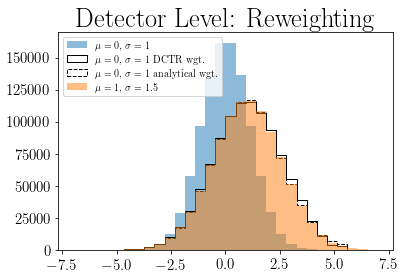

In [13]:
bins = np.linspace(-7, 7, 31)
plt.hist(X0_val_D, bins=bins, alpha=0.5, label=r'$\mu=0$, $\sigma=1$')
plt.hist(X0_val_D,
         bins=bins,
         label=r'$\mu=0$, $\sigma=1$ DCTR wgt.',
         weights=weights,
         histtype='step',
         color='k')
plt.hist(X0_val_D,
         bins=bins,
         label=r'$\mu=0$, $\sigma=1$ analytical wgt.',
         weights=analytical_weights,
         histtype='step',
         linestyle='--',
         color='k')
plt.hist(X1_val_D,
         bins=bins,
         alpha=0.5,
         label=r'$\mu={}$, $\sigma={}$'.format(mu1, sigma1))
plt.legend(prop=fontP, loc='upper left')
plt.title("Detector Level: Reweighting")
#plt.savefig("GaussianAltFit-2D-Detector-Level:Reweighting.png")
plt.show()

## Saving Model

In [14]:
'''
model_json = dctr_model.to_json()
with open("2d_gaussian_dctr_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
dctr_model.save_weights("2d_gaussian_dctr_model.h5")
print("Saved model to disk")
'''

'\nmodel_json = dctr_model.to_json()\nwith open("2d_gaussian_dctr_model.json", "w") as json_file:\n    json_file.write(model_json)\n# serialize weights to HDF5\ndctr_model.save_weights("2d_gaussian_dctr_model.h5")\nprint("Saved model to disk")\n'

# Alternative Fit

## Setup the dataset

We'll show the new setup with a simple Gaussian example.  Let's start by setting up the dataset.

To apply detector effects, each event $x_{T,i}$in the sample is smeared by shifting by $Z_{i}$ from $Z = \mathcal{N}(0,\epsilon)$,where $\epsilon$ represents the smearing. Thus: $x_{D,i} = x_{T,i} + Z_{i}$

In [15]:
N = 10**6
# param = (mu, sigma)
# this is the simulation ... N.B. this notation is reversed from above!
theta0_param = (0, 1)
# this is the data (the target)
theta1_param = (1, 1.5)

epsilon = theta0_param[1] / 2  # Smearing width

theta0_T = np.random.normal(theta0_param[0], theta0_param[1], N)
theta0_D = np.array([(x + np.random.normal(0, epsilon))
                     for x in theta0_T])  #Detector smearing
theta0 = np.stack([theta0_T, theta0_D], axis=1)

theta1_T = np.random.normal(theta1_param[0], theta1_param[1], N)
theta1_D = np.array([(x + np.random.normal(0, epsilon))
                     for x in theta1_T])  #Detector smearing
theta1 = np.stack([theta1_T, theta1_D], axis=1)

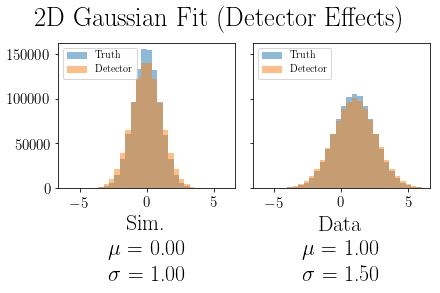

In [16]:
bins = np.linspace(-6, 6, 31)

fig, axs = plt.subplots(1, 2, sharey=True, constrained_layout=True)
fig.suptitle('2D Gaussian Fit (Detector Effects)')

axs[0].set_xlabel("Sim.\n$\mu$ = {:.2f}\n$\sigma$ = {:.2f}".format(
    theta0_param[0], theta0_param[1]))
axs[0].hist(theta0_T, bins=bins, alpha=0.5, label='Truth')
axs[0].hist(theta0_D, bins=bins, alpha=0.5, label='Detector')
axs[0].legend(prop=fontP, loc='upper left')

axs[1].set_xlabel("Data\n$\mu$ = {:.2f}\n$\sigma$ = {:.2f}".format(
    theta1_param[0], theta1_param[1]))
axs[1].hist(theta1_T, bins=bins, alpha=0.5, label='Truth')
axs[1].hist(theta1_D, bins=bins, alpha=0.5, label='Detector')
axs[1].legend(prop=fontP, loc='upper left')
# fig.savefig("GaussianAltFit-2D-Fitting-Data-with-Detector-Effects.png")
fig.show()

In [17]:
labels0 = np.zeros(len(theta0))
labels1 = np.ones(len(theta1))

xvals = np.concatenate([theta0, theta1])
yvals = np.concatenate([labels0, labels1])

X_train, X_test, y_train, y_test = train_test_split(xvals,
                                                    yvals,
                                                    test_size=0.5)
X_train_theta, y_train_theta = shuffle(xvals, yvals)

X_train_T, y_train_T = np.copy(X_train[:, 0]), y_train
X_test_T, y_test_T = np.copy(X_test[:, 0]), y_test
X_train_theta_T, y_train_theta_T = np.copy(X_train_theta[:, 0]), y_train_theta

#'Erasing' Truth level for data, we can't actually observe this
X_train[:, 0][y_train == 1], X_test[:, 0][y_test == 1] = 0., 0.
X_train_theta[:, 0][y_train_theta_T == 1] = 0.

# 'hiding' truth level for simulation in model output (used in reweighting)
X_train_D, y_train_D = X_train[:, 1], np.stack([y_train, X_train[:, 0]],
                                               axis=1)
X_test_D, y_test_D = X_test[:, 1], np.stack([y_test, X_test[:, 0]], axis=1)

X_train_theta_D, y_train_theta_D = X_train_theta[:, 1], np.stack(
    [y_train_theta, X_train_theta[:, 0]], axis=1)

## Fitting Model: Scan

We'll start by showing that for fixed $\theta$, the maximum loss occurs when $\theta=\theta_1$.

### Creating Model

In [18]:
myinputs = Input(shape=(1, ), dtype=tf.float32)
x = Dense(128, activation='relu')(myinputs)
x2 = Dense(128, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x2)

model = Model(inputs=myinputs, outputs=predictions)
model.summary()
batch_size = 1000

earlystopping = EarlyStopping(patience=5, restore_best_weights=True)

thetas_mu = np.linspace(-2, 2, 17)
thetas_sigma = np.linspace(0.5, 4.5, 17)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               256       
_________________________________________________________________
dense_6 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 129       
Total params: 16,897
Trainable params: 16,897
Non-trainable params: 0
_________________________________________________________________


### Truth Level Scan

In [19]:
def my_loss_wrapper_T(inputs,
                      val=0.,
                      fit='mu',
                      reweight_type='DCTR',
                      loss='MSE',
                      batch_size=1000):
    x = inputs
    x = K.gather(x, np.arange(batch_size))

    if fit == 'mu':
        theta_prime = [val, theta1_param[1]]  # fixed theta_sigma = sigma_truth
    elif fit == 'sigma':
        theta_prime = [theta1_param[0], val]  # fixed theta_mu = mu_truth
    else:
        raise ValueError("fit must be set to 'mu' or 'sigma'")

    if reweight_type == 'DCTR':
        # NN (DCTR) reweight
        weights = reweight(events=x, param=theta_prime)
    elif reweight_type == 'analytical':
        # analytical reweight
        weights = analytical_reweight(events=x, param=theta_prime)
    else:
        raise ValueError("reweight_type must be set to 'DCTR' or 'analytical'")

    def my_loss(y_true, y_pred):
        if loss == 'MSE':
            # Mean Squared Loss
            t_loss = y_true * (y_true - y_pred)**2 + weights * (
                1. - y_true) * (y_true - y_pred)**2
        elif loss == 'categorical_crossentropy':
            # Categorical Cross-Entropy Loss

            # Clip the prediction value to prevent NaN's and Inf's
            epsilon = K.epsilon()
            y_pred = K.clip(y_pred, epsilon, 1. - epsilon)

            t_loss = -((y_true) * K.log(y_pred) + weights *
                       (1 - y_true) * K.log(1 - y_pred))
        else:
            raise ValueError(
                "loss must be set to 'MSE' or 'categorical_crossentropy'")

        return K.mean(t_loss)

    return my_loss

#### Cross Section for $\mu$

In [20]:
lvals_mu_T = []
vlvals_mu_T = []

for theta in thetas_mu:
    print("Testing theta = (", theta, ", 1.5 )")
    model.compile(optimizer='adam',
                  loss=my_loss_wrapper_T(myinputs,
                                         theta,
                                         fit='mu',
                                         reweight_type='analytical',
                                         loss='categorical_crossentropy',
                                         batch_size=batch_size),
                  metrics=['accuracy'])
    history = model.fit(np.array(X_train_T),
                        y_train_T,
                        epochs=100,
                        batch_size=batch_size,
                        validation_data=(np.array(X_test_T), y_test_T),
                        verbose=0,
                        callbacks=[earlystopping])

    min_lval = np.min(history.history['loss'])
    min_vlval = np.min(history.history['val_loss'])

    lvals_mu_T += [min_lval]
    vlvals_mu_T += [min_vlval]

    print("loss: ", min_lval)
    print("val_loss: ", min_vlval)
    print("\n")
    pass

Testing theta = ( -2.0 , 1.5 )
loss:  0.3563811983764172
val_loss:  0.356507833480835


Testing theta = ( -1.75 , 1.5 )
loss:  0.394351629704237
val_loss:  0.39442958050966265


Testing theta = ( -1.5 , 1.5 )
loss:  0.43303976094722746
val_loss:  0.4330905780494213


Testing theta = ( -1.25 , 1.5 )
loss:  0.47189463117718694
val_loss:  0.4718324220776558


Testing theta = ( -1.0 , 1.5 )
loss:  0.5101453270912171
val_loss:  0.5099393758475781


Testing theta = ( -0.75 , 1.5 )
loss:  0.5469638947844505
val_loss:  0.5465872813463211


Testing theta = ( -0.5 , 1.5 )
loss:  0.5814806968569756
val_loss:  0.5809064292311669


Testing theta = ( -0.25 , 1.5 )
loss:  0.612797070980072
val_loss:  0.6118976579904556


Testing theta = ( 0.0 , 1.5 )
loss:  0.6399046440124512
val_loss:  0.6386907275915146


Testing theta = ( 0.25 , 1.5 )
loss:  0.6619094905853271
val_loss:  0.6604617569446564


Testing theta = ( 0.5 , 1.5 )
loss:  0.6774896511435509
val_loss:  0.6762779830098152


Testing theta = ( 0

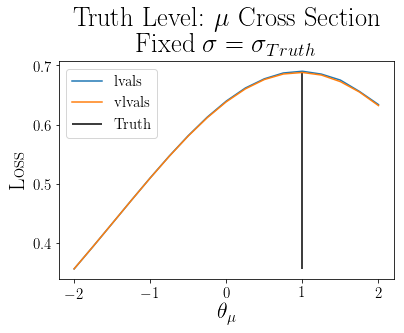

In [21]:
plt.plot(thetas_mu, lvals_mu_T, label='lvals')
plt.plot(thetas_mu, vlvals_mu_T, label='vlvals')
plt.title("Truth Level: $\mu$ Cross Section\nFixed $\sigma = \sigma_{Truth}$")
plt.xlabel(r'$\theta_{\mu}$')
plt.ylabel('Loss')
plt.vlines(theta1_param[0],
           ymin=np.min(lvals_mu_T),
           ymax=np.max(lvals_mu_T),
           label='Truth')
plt.legend()
#plt.savefig("GaussianAltFit-2D-Truth Level:-$\mu$-Cross-Section\nFixed-$\sigma=\sigma_{Truth}$.png")
plt.show()

#### Cross Section for $\sigma$

In [22]:
lvals_sigma_T = []
vlvals_sigma_T = []

for theta in thetas_sigma:
    print("Testing theta = ( 1. ,", theta, ")")
    model.compile(optimizer='adam',
                  loss=my_loss_wrapper_T(myinputs,
                                         theta,
                                         fit='sigma',
                                         loss='categorical_crossentropy',
                                         batch_size=batch_size),
                  metrics=['accuracy'])
    history = model.fit(np.array(X_train_T),
                        y_train_T,
                        epochs=100,
                        batch_size=batch_size,
                        validation_data=(np.array(X_test_T), y_test_T),
                        verbose=0,
                        callbacks=[earlystopping])

    min_lval = np.min(history.history['loss'])
    min_vlval = np.min(history.history['val_loss'])

    lvals_sigma_T += [min_lval]
    vlvals_sigma_T += [min_vlval]

    print("loss: ", min_lval)
    print("val_loss: ", min_vlval)
    print("\n")
    pass

Testing theta = ( 1. , 0.5 )
loss:  0.49478229919075967
val_loss:  0.49434705993533135


Testing theta = ( 1. , 0.75 )
loss:  0.604186897277832
val_loss:  0.6030440704226494


Testing theta = ( 1. , 1.0 )
loss:  0.6577146420478821
val_loss:  0.6558941833972931


Testing theta = ( 1. , 1.25 )
loss:  0.6834097987413407
val_loss:  0.6810917131900788


Testing theta = ( 1. , 1.5 )
loss:  0.6937707658410073
val_loss:  0.6917694881558418


Testing theta = ( 1. , 1.75 )
loss:  0.6857634711265564
val_loss:  0.6840454105734826


Testing theta = ( 1. , 2.0 )
loss:  0.6662975562810898
val_loss:  0.6655630575418472


Testing theta = ( 1. , 2.25 )
loss:  0.6482806905508042
val_loss:  0.6460273012518882


Testing theta = ( 1. , 2.5 )
loss:  0.6246082651019096
val_loss:  0.6256867269873619


Testing theta = ( 1. , 2.75 )
loss:  0.604090462744236
val_loss:  0.6023303374648095


Testing theta = ( 1. , 3.0 )
loss:  0.5820729415416718
val_loss:  0.580618044435978


Testing theta = ( 1. , 3.25 )
loss:  0.

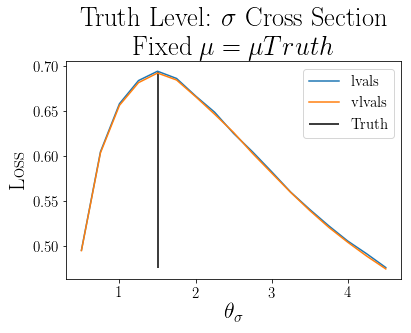

In [23]:
plt.plot(thetas_sigma, lvals_sigma_T, label='lvals')
plt.plot(thetas_sigma, vlvals_sigma_T, label='vlvals')
plt.title("Truth Level: $\sigma$ Cross Section\nFixed $\mu = \mu{Truth}$")
plt.xlabel(r'$\theta_{\sigma}$')
plt.ylabel('Loss')
plt.vlines(theta1_param[1],
           ymin=np.min(lvals_sigma_T),
           ymax=np.max(lvals_sigma_T),
           label='Truth')
plt.legend()
#plt.savefig("GaussianAltFit-2D-Truth-Level:$\sigma$-Cross-Section\nFixed-$\mu=\mu{Truth}$.png")
plt.show()

### Detector Level Scan

In [24]:
def my_loss_wrapper_D(val=0.,
                      fit='mu',
                      reweight_type='DCTR',
                      loss='MSE',
                      batch_size=1000):
    def my_loss(y_true, y_pred):
        y_true = tf.gather(y_true, np.arange(batch_size))
        x_T = tf.gather(y_true, [1], axis=1)  # sim truth for reweighting
        y_true = tf.gather(y_true, [0], axis=1)  #actual y_true for loss

        if fit == 'mu':
            # fixed theta_sigma = sigma_truth
            theta_prime = [val, theta1_param[1]]
        elif fit == 'sigma':
            # fixed theta_mu = mu_truth
            theta_prime = [theta1_param[0], val]
        else:
            raise ValueError("fit must be set to 'mu' or 'sigma'")

        if reweight_type == 'DCTR':
            # NN (DCTR) reweight
            weights = reweight(events=x_T, param=theta_prime)
        elif reweight_type == 'analytical':
            # analytical reweight
            weights = analytical_reweight(events=x_T, param=theta_prime)
        else:
            raise ValueError(
                "reweight_type must be set to 'DCTR' or 'analytical'")

        if loss == 'MSE':
            # Mean Squared Loss
            t_loss = y_true * (y_true - y_pred)**2 + weights * (
                1. - y_true) * (y_true - y_pred)**2
        elif loss == 'categorical_crossentropy':
            # Categorical Cross-Entropy Loss

            # Clip the prediction value to prevent NaN's and Inf's
            epsilon = K.epsilon()
            y_pred = K.clip(y_pred, epsilon, 1. - epsilon)

            t_loss = -((y_true) * K.log(y_pred) + weights *
                       (1 - y_true) * K.log(1 - y_pred))
        else:
            raise ValueError(
                "loss must be set to 'MSE' or 'categorical_crossentropy'")

        return K.mean(t_loss)

    return my_loss

#### Cross Section for $\mu$

In [25]:
lvals_mu_D = []
vlvals_mu_D = []

for theta in thetas_mu:
    print("Testing theta = (", theta, ", 1.5 )")
    model.compile(optimizer='adam',
                  loss=my_loss_wrapper_D(theta,
                                         fit='mu',
                                         loss='categorical_crossentropy',
                                         batch_size=batch_size),
                  metrics=['accuracy'])

    history = model.fit(np.array(X_train_D),
                        y_train_D,
                        epochs=100,
                        batch_size=batch_size,
                        validation_data=(np.array(X_test_D), y_test_D),
                        verbose=0,
                        callbacks=[earlystopping])

    min_lval = np.min(history.history['loss'])
    min_vlval = np.min(history.history['val_loss'])

    lvals_mu_D += [min_lval]
    vlvals_mu_D += [min_vlval]

    print("loss: ", min_lval)
    print("val_loss: ", min_vlval)
    print("\n")
    pass

Testing theta = ( -2.0 , 1.5 )
loss:  0.38206953811645505
val_loss:  0.38231678181886675


Testing theta = ( -1.75 , 1.5 )
loss:  0.41560672962665557
val_loss:  0.4158382743000984


Testing theta = ( -1.5 , 1.5 )
loss:  0.4520000543296337
val_loss:  0.452115571975708


Testing theta = ( -1.25 , 1.5 )
loss:  0.4906436649858952
val_loss:  0.4906958851218224


Testing theta = ( -1.0 , 1.5 )
loss:  0.5288333357870578
val_loss:  0.5287722719609738


Testing theta = ( -0.75 , 1.5 )
loss:  0.5617633530497551
val_loss:  0.561508627474308


Testing theta = ( -0.5 , 1.5 )
loss:  0.59247934705019
val_loss:  0.5920942419171333


Testing theta = ( -0.25 , 1.5 )
loss:  0.6197404062151909
val_loss:  0.6192974911332131


Testing theta = ( 0.0 , 1.5 )
loss:  0.6415161842107773
val_loss:  0.6408353375196457


Testing theta = ( 0.25 , 1.5 )
loss:  0.661428454875946
val_loss:  0.6606207466721534


Testing theta = ( 0.5 , 1.5 )
loss:  0.6795207100510597
val_loss:  0.6785609360337257


Testing theta = ( 0.7

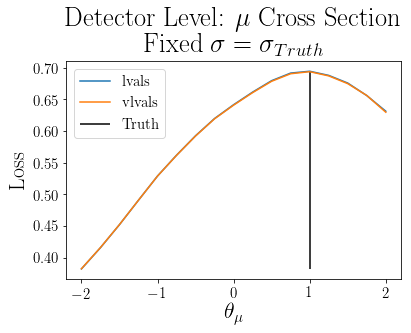

In [26]:
plt.plot(thetas_mu, lvals_mu_D, label='lvals')
plt.plot(thetas_mu, vlvals_mu_D, label='vlvals')
plt.title(
    "Detector Level: $\mu$ Cross Section\nFixed $\sigma = \sigma_{Truth}$")
plt.xlabel(r'$\theta_{\mu}$')
plt.ylabel('Loss')
plt.vlines(theta1_param[0],
           ymin=np.min(lvals_mu_D),
           ymax=np.max(lvals_mu_D),
           label='Truth')
plt.legend()
#plt.savefig("GaussianAltFit-2D-Detector Level:$\mu$-Cross-Section\nFixed-$\sigma=\sigma_{Truth}$.png")
plt.show()

#### Cross Section for $\sigma$

In [27]:
lvals_sigma_D = []
vlvals_sigma_D = []

for theta in thetas_sigma:
    print("Testing theta = ( 1. ,", theta, ")")
    model.compile(optimizer='adam',
                  loss=my_loss_wrapper_D(theta,
                                         fit='sigma',
                                         loss='categorical_crossentropy',
                                         batch_size=batch_size),
                  metrics=['accuracy'])

    history = model.fit(np.array(X_train_D),
                        y_train_D,
                        epochs=100,
                        batch_size=batch_size,
                        validation_data=(np.array(X_test_D), y_test_D),
                        verbose=0,
                        callbacks=[earlystopping])

    min_lval = np.min(history.history['loss'])
    min_vlval = np.min(history.history['val_loss'])

    lvals_sigma_D += [min_lval]
    vlvals_sigma_D += [min_vlval]

    print("loss: ", min_lval)
    print("val_loss: ", min_vlval)
    print("\n")
    pass

Testing theta = ( 1. , 0.5 )
loss:  0.5612861627936363
val_loss:  0.5613098030686379


Testing theta = ( 1. , 0.75 )
loss:  0.6310191224813462
val_loss:  0.6308747689127923


Testing theta = ( 1. , 1.0 )
loss:  0.6657634293437004
val_loss:  0.6649775677919387


Testing theta = ( 1. , 1.25 )
loss:  0.6847214698791504
val_loss:  0.6840068472027778


Testing theta = ( 1. , 1.5 )
loss:  0.6943612751364708
val_loss:  0.6935539031028748


Testing theta = ( 1. , 1.75 )
loss:  0.6874460383057595
val_loss:  0.6880211619138717


Testing theta = ( 1. , 2.0 )
loss:  0.6706150486469269
val_loss:  0.6708307669162751


Testing theta = ( 1. , 2.25 )
loss:  0.6508852406144142
val_loss:  0.6511291866898536


Testing theta = ( 1. , 2.5 )
loss:  0.631899252295494
val_loss:  0.6362332296967507


Testing theta = ( 1. , 2.75 )
loss:  0.6103076705932617
val_loss:  0.6090859994888306


Testing theta = ( 1. , 3.0 )
loss:  0.5879429546296596
val_loss:  0.5926002606153488


Testing theta = ( 1. , 3.25 )
loss:  0.

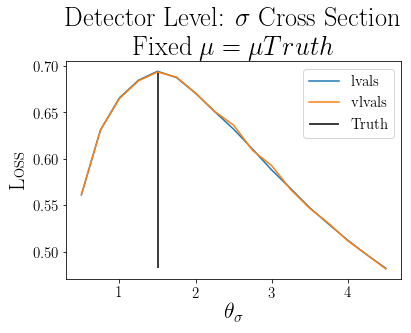

In [28]:
plt.plot(thetas_sigma, lvals_sigma_D, label='lvals')
plt.plot(thetas_sigma, vlvals_sigma_D, label='vlvals')
plt.title("Detector Level: $\sigma$ Cross Section\nFixed $\mu = \mu{Truth}$")
plt.xlabel(r'$\theta_{\sigma}$')
plt.ylabel('Loss')
plt.vlines(theta1_param[1],
           ymin=np.min(lvals_sigma_D),
           ymax=np.max(lvals_sigma_D),
           label='Truth')
plt.legend()
#plt.savefig("GaussianAltFit-2D-Detector Level:$\sigma$-Cross-Section\nFixed-$\mu=\mu{Truth}$.png")
plt.show()

### Comparison Plot

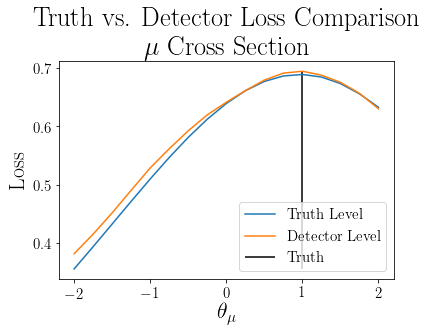

In [29]:
plt.plot(thetas_mu, vlvals_mu_T, label='Truth Level')
plt.plot(thetas_mu, vlvals_mu_D, label='Detector Level')
plt.xlabel(r'$\theta_{\mu}$')
plt.ylabel('Loss')
plt.vlines(theta1_param[0],
           ymin=np.min(vlvals_mu_T + vlvals_mu_D),
           ymax=np.max(vlvals_mu_T + vlvals_mu_D),
           label='Truth')
plt.title("Truth vs. Detector Loss Comparison\n$\mu$ Cross Section")
plt.legend()
#plt.savefig("GaussianAltFit-2D-Truth-vs-Detector-Loss-Comparison\n$\mu$-Cross-Section.png")
plt.show()

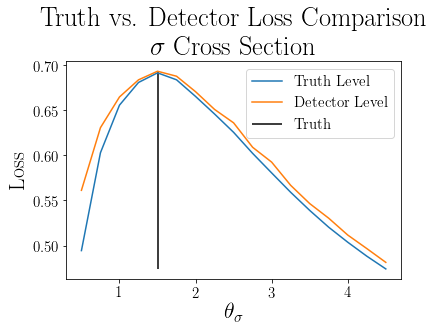

In [30]:
plt.plot(thetas_sigma, vlvals_sigma_T, label='Truth Level')
plt.plot(thetas_sigma, vlvals_sigma_D, label='Detector Level')
plt.xlabel(r'$\theta_{\sigma}$')
plt.ylabel('Loss')
plt.vlines(theta1_param[1],
           ymin=np.min(vlvals_sigma_T + vlvals_sigma_D),
           ymax=np.max(vlvals_sigma_T + vlvals_sigma_D),
           label='Truth')
plt.title("Truth vs. Detector Loss Comparison\n$\sigma$ Cross Section")
plt.legend()
#plt.savefig("GaussianAltFit-2D-Truth-vs-Detector-Loss-Comparison\n$\sigma$-Cross-Section.png")
plt.show()

We've shown for fixed $\theta$, the maximum loss occurs when $\theta=\theta_1$

Now, let's do the $\theta$ and $g$ optimization together with a minimax setup.

## Fitting Model: Gradient Fit

### Creating Model

In [31]:
print_weights = LambdaCallback(on_epoch_end=lambda batch, logs: print(
    "Theta fit = ", model_fit.layers[-1].get_weights()[-1]))

theta_fit_init = [0., 1.]
fit_vals = [theta_fit_init]
append_fit_value = LambdaCallback(
    on_epoch_end=lambda batch, logs: fit_vals.append(model_fit.layers[-1].
                                                     get_weights()[0]))

callbacks = [print_weights, append_fit_value]

earlystopping = EarlyStopping(patience=10, restore_best_weights=True)

In [32]:
myinputs_fit = Input(shape=(1, ))
x_fit = Dense(128, activation='relu')(myinputs_fit)
x2_fit = Dense(128, activation='relu')(x_fit)
predictions_fit = Dense(1, activation='sigmoid')(x2_fit)
identity = Lambda(lambda x: x + 0)(predictions_fit)

model_fit = Model(inputs=myinputs_fit, outputs=identity)
model_fit.layers[np.size(model_fit.layers) - 1].add_weight(
    name="thetaX",
    shape=(2, ),
    initializer=keras.initializers.Constant(value=theta_fit_init),
    trainable=True)
model_fit.summary()

batch_size_g = 1000
batch_size_theta = 2 * N
iterations = 50

# optimizer will be refined as fit progresses for better precision
lr_initial = 5e-1
optimizer = keras.optimizers.Adam(lr=lr_initial)
index_refine = np.array([0])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)               256       
_________________________________________________________________
dense_9 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 129       
_________________________________________________________________
lambda_1 (Lambda)            (None, 1)                 2         
Total params: 16,899
Trainable params: 16,899
Non-trainable params: 0
_________________________________________________________________


### Truth Level Gradient Fit

In [33]:
def my_loss_wrapper_fit_T(
        inputs,
        mysign=1,  # -1 for training theta, +1 for training g
        reweight_type='DCTR',
        loss='MSE',
        batch_size=1000):

    x = inputs
    x = K.gather(x, np.arange(batch_size))

    # Getting theta_prime:
    if mysign == 1:
        # when not training theta, fetch as np array
        theta_prime = model_fit.layers[-1].get_weights()[0]
    else:
        # when training theta, fetch as tf.Variable
        theta_prime = model_fit.trainable_weights[-1]
    if reweight_type == 'DCTR':
        # DCTR (NN) reweight
        weights = reweight(x, theta_prime)
    elif reweight_type == 'analytical':
        # analytical reweight
        weights = analytical_reweight(x, theta_prime)
    else:
        raise ValueError("reweight_type must be set to 'DCTR' or 'analytical'")

    def my_loss(y_true, y_pred):
        if loss == 'MSE':
            # Mean Squared Loss
            t_loss = mysign * (y_true * (y_true - y_pred)**2 + weights *
                               (1. - y_true) * (y_true - y_pred)**2)
        elif loss == 'categorical_crossentropy':
            # Categorical Cross-Entropy Loss

            # Clip the prediction value to prevent NaN's and Inf's
            epsilon = K.epsilon()
            y_pred = K.clip(y_pred, epsilon, 1. - epsilon)

            t_loss = -mysign * ((y_true) * K.log(y_pred) + weights *
                                (1 - y_true) * K.log(1 - y_pred))
        else:
            raise ValueError(
                "loss must be set to 'MSE' or 'categorical_crossentropy'")

        return K.mean(t_loss)

    return my_loss

In [34]:
for iteration in range(iterations):
    print("Iteration: ", iteration)

    # Reshuffling Training Data:
    X_train, X_test, y_train, y_test = train_test_split(xvals,
                                                        yvals,
                                                        test_size=0.5)

    X_train_T, y_train_T = np.copy(X_train[:, 0]), y_train
    X_test_T, y_test_T = np.copy(X_test[:, 0]), y_test

    # fix \theta and train g
    for i in range(len(model_fit.layers) - 1):
        model_fit.layers[i].trainable = True
        pass

    model_fit.layers[-1].trainable = False
    #model.summary()

    model_fit.compile(optimizer='Adam',
                      loss=my_loss_wrapper_fit_T(
                          myinputs_fit,
                          1,
                          loss='categorical_crossentropy',
                          batch_size=batch_size_g),
                      metrics=['accuracy'])

    print("Training g")
    model_fit.fit(np.array(X_train_T),
                  y_train_T,
                  epochs=100,
                  batch_size=batch_size_g,
                  validation_data=(np.array(X_test_T), y_test_T),
                  verbose=0,
                  callbacks=[earlystopping])

    #Now, fix g and train \theta.

    for i in range(len(model_fit.layers) - 1):
        model_fit.layers[i].trainable = False
        pass

    model_fit.layers[-1].trainable = True

    # special optimizer and batch size = 2*N
    model_fit.compile(optimizer=optimizer,
                      loss=my_loss_wrapper_fit_T(
                          myinputs_fit,
                          -1,
                          loss='categorical_crossentropy',
                          batch_size=batch_size_theta),
                      metrics=['accuracy'])
    #model.summary()
    print("Training theta")
    model_fit.fit(np.array(X_train_theta_T),
                  y_train_theta,
                  epochs=1,
                  batch_size=batch_size_theta,
                  verbose=0,
                  callbacks=callbacks)

    print("\n")

    # Detecting oscillatory behavior (oscillations around truth values)
    # Then refine fit by decreasing learning rate /10

    fit_vals_mu = np.array(fit_vals)[(index_refine[-1]):, 0]
    fit_vals_sigma = np.array(fit_vals)[(index_refine[-1]):, 1]

    # Get RECENT relative extrema, if it alternates --> oscillatory behavior
    extrema_mu = np.concatenate(
        (argrelmin(fit_vals_mu)[0], argrelmax(fit_vals_mu)[0]))
    extrema_mu = extrema_mu[extrema_mu >= iteration - index_refine[-1] - 20]

    extrema_sigma = np.concatenate(
        (argrelmin(fit_vals_sigma)[0], argrelmax(fit_vals_sigma)[0]))
    extrema_sigma = extrema_sigma[extrema_sigma >= iteration -
                                  index_refine[-1] - 20]

    if (len(extrema_mu) == 0) or (
            len(extrema_sigma)
            == 0):  # If none are found, keep fitting (catching index error)
        pass
    elif (len(extrema_mu) >= 6) and (len(extrema_sigma) >=
                                     6):  #If enough are found, refine fit
        index_refine = np.append(index_refine, iteration + 1)
        print('==============================\n' +
              '====Refining Learning Rate====\n' +
              '==============================')
        optimizer.lr = optimizer.lr / 10

        mean_fit = np.array([[
            np.mean(fit_vals_mu[len(fit_vals_mu) - 4:len(fit_vals_mu)]),
            np.mean(fit_vals_sigma[len(fit_vals_sigma) -
                                   4:len(fit_vals_sigma)])
        ]])

        model_fit.layers[-1].set_weights(mean_fit)
    pass

Iteration:  0
Training g
Training theta
Theta fit =  [0.499987  1.4999893]


Iteration:  1
Training g
Training theta
Theta fit =  [0.8720364 1.8719733]


Iteration:  2
Training g
Training theta
Theta fit =  [1.191188 1.552578]


Iteration:  3
Training g
Training theta
Theta fit =  [0.9006518 1.2621092]


Iteration:  4
Training g
Training theta
Theta fit =  [1.173339  1.5348392]


Iteration:  5
Training g
Training theta
Theta fit =  [0.9123023 1.273863 ]


Iteration:  6
Training g
Training theta
Theta fit =  [1.1654305 1.5270388]


Iteration:  7
Training g
Training theta
Theta fit =  [0.91757786 1.7745478 ]


Iteration:  8
Training g
Training theta
Theta fit =  [1.1616651 1.5301831]


Iteration:  9
Training g
Training theta
Theta fit =  [0.91947234 1.2880409 ]


Iteration:  10
Training g
Training theta
Theta fit =  [1.1604749 1.5290945]


====Refining Learning Rate====
Iteration:  11
Training g
Training theta
Theta fit =  [1.0157306 1.5064054]


Iteration:  12
Training g
Training theta


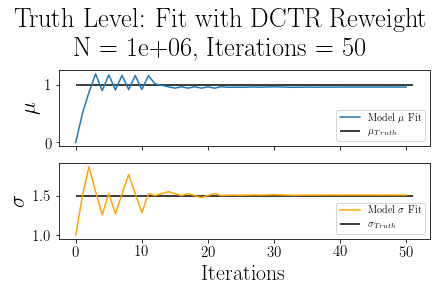

In [35]:
fit_vals = np.array(fit_vals)
fig, axs = plt.subplots(2, sharex=True, constrained_layout=True)
fig.suptitle(
    "Truth Level: Fit with DCTR Reweight\nN = {:.0e}, Iterations = {:.0f}".
    format(N, iterations))
axs[0].plot(fit_vals[:, 0], label='Model $\mu$ Fit')
axs[0].hlines(theta1_param[0], 0, len(fit_vals), label='$\mu_{Truth}$')
axs[0].set_ylabel(r'$\mu$')
axs[0].legend(prop=fontP)

axs[1].plot(fit_vals[:, 1], label='Model $\sigma$ Fit', color='orange')
axs[1].hlines(theta1_param[1], 0, len(fit_vals), label='$\sigma_{Truth}$')
axs[1].set_ylabel(r'$\sigma$')
axs[1].legend(prop=fontP)
plt.xlabel("Iterations")
# plt.savefig(
#     "GaussianAltFit-2D-Truth-Level:Fit-with-DCTR Reweight\nN ={:.0e},Iterations={:.0f}.png".
#     format(N, iterations))
plt.show()

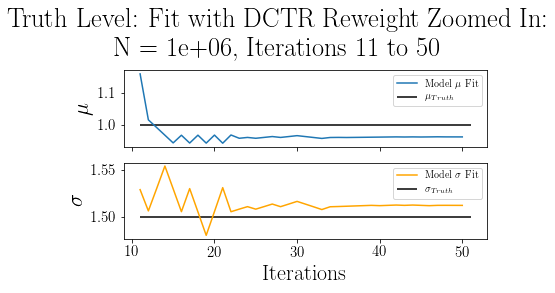

In [36]:
# Zoom into later iterations (finer fit)

fit_vals = np.array(fit_vals)
fig, axs = plt.subplots(2, sharex=True, constrained_layout=True)
fig.suptitle(
    "Truth Level: Fit with DCTR Reweight Zoomed In:\n N = {:.0e}, Iterations {:.0f} to {:.0f}"
    .format(N, index_refine[1], iterations))
axs[0].plot(np.arange(index_refine[1], len(fit_vals[:, 0])),
            fit_vals[index_refine[1]:, 0],
            label='Model $\mu$ Fit')
axs[0].hlines(theta1_param[0],
              index_refine[1],
              len(fit_vals),
              label='$\mu_{Truth}$')
axs[0].set_ylabel(r'$\mu$')
axs[0].legend(prop=fontP)

axs[1].plot(np.arange(index_refine[1], len(fit_vals[:, 1])),
            fit_vals[index_refine[1]:, 1],
            label='Model $\sigma$ Fit',
            color='orange')
axs[1].hlines(theta1_param[1],
              index_refine[1],
              len(fit_vals),
              label='$\sigma_{Truth}$')
axs[1].set_ylabel(r'$\sigma$')
axs[1].legend(prop=fontP)
plt.xlabel("Iterations")
# plt.savefig(
#     "GaussianAltFit-2D-Truth-Level:Fit-with-DCTR-Reweight-Zoomed-In:\n-N ={:.0e}-Iterations-{:.0f}-to-{:.0f}.png"
#     .format(N, index_refine[1], iterations))
plt.show()

#### Compare Fitting between DCTR Reweighting and Analytical Reweighting

In [37]:
# Reset parameters

fit_vals = [theta_fit_init]
model_fit.layers[-1].set_weights(np.array([theta_fit_init]))
optimizer = keras.optimizers.Adam(lr=lr_initial)
index_refine = np.array([0])

In [38]:
for iteration in range(iterations):
    print("Iteration: ", iteration)

    # Reshuffling Training Data:
    X_train, X_test, y_train, y_test = train_test_split(xvals,
                                                        yvals,
                                                        test_size=0.5)

    X_train_T, y_train_T = np.copy(X_train[:, 0]), y_train
    X_test_T, y_test_T = np.copy(X_test[:, 0]), y_test

    # fix \theta and train g
    for i in range(len(model_fit.layers) - 1):
        model_fit.layers[i].trainable = True
        pass

    model_fit.layers[-1].trainable = False
    #model.summary()

    model_fit.compile(optimizer='Adam',
                      loss=my_loss_wrapper_fit_T(
                          myinputs_fit,
                          1,
                          reweight_type='analytical',
                          loss='categorical_crossentropy',
                          batch_size=batch_size_g),
                      metrics=['accuracy'])

    print("Training g")
    model_fit.fit(np.array(X_train_T),
                  y_train_T,
                  epochs=100,
                  batch_size=batch_size_g,
                  validation_data=(np.array(X_test_T), y_test_T),
                  verbose=0,
                  callbacks=[earlystopping])

    #Now, fix g and train \theta.

    for i in range(len(model_fit.layers) - 1):
        model_fit.layers[i].trainable = False
        pass

    model_fit.layers[-1].trainable = True

    # special optimizer and batch size = 2*N
    model_fit.compile(optimizer=optimizer,
                      loss=my_loss_wrapper_fit_T(
                          myinputs_fit,
                          -1,
                          reweight_type='analytical',
                          loss='categorical_crossentropy',
                          batch_size=batch_size_theta),
                      metrics=['accuracy'])
    #model.summary()
    print("Training theta")
    model_fit.fit(np.array(X_train_theta_T),
                  y_train_theta,
                  epochs=1,
                  batch_size=batch_size_theta,
                  verbose=0,
                  callbacks=callbacks)

    print("\n")

    # Detecting oscillatory behavior (oscillations around truth values)
    # Then refine fit by decreasing learning rate /10

    fit_vals_mu = np.array(fit_vals)[(index_refine[-1]):, 0]
    fit_vals_sigma = np.array(fit_vals)[(index_refine[-1]):, 1]

    # Get RECENT relative extrema, if it alternates --> oscillatory behavior
    extrema_mu = np.concatenate(
        (argrelmin(fit_vals_mu)[0], argrelmax(fit_vals_mu)[0]))
    extrema_mu = extrema_mu[extrema_mu >= iteration - index_refine[-1] - 20]

    extrema_sigma = np.concatenate(
        (argrelmin(fit_vals_sigma)[0], argrelmax(fit_vals_sigma)[0]))
    extrema_sigma = extrema_sigma[extrema_sigma >= iteration -
                                  index_refine[-1] - 20]

    if (len(extrema_mu) == 0) or (
            len(extrema_sigma)
            == 0):  # If none are found, keep fitting (catching index error)
        pass
    elif (len(extrema_mu) >= 6) and (len(extrema_sigma) >=
                                     6):  #If enough are found, refine fit
        index_refine = np.append(index_refine, iteration + 1)
        print('==============================\n' +
              '====Refining Learning Rate====\n' +
              '==============================')
        optimizer.lr = optimizer.lr / 10

        mean_fit = np.array([[
            np.mean(fit_vals_mu[len(fit_vals_mu) - 4:len(fit_vals_mu)]),
            np.mean(fit_vals_sigma[len(fit_vals_sigma) -
                                   4:len(fit_vals_sigma)])
        ]])

        model_fit.layers[-1].set_weights(mean_fit)
    pass

Iteration:  0
Training g
Training theta
Theta fit =  [0.49998668 1.4999906 ]


Iteration:  1
Training g
Training theta
Theta fit =  [0.87203324 1.8719963 ]


Iteration:  2
Training g
Training theta
Theta fit =  [1.1913549 1.5526094]


Iteration:  3
Training g
Training theta
Theta fit =  [0.9008322 1.2621179]


Iteration:  4
Training g
Training theta
Theta fit =  [1.1618242 1.5231628]


Iteration:  5
Training g
Training theta
Theta fit =  [0.9007982 1.2621961]


Iteration:  6
Training g
Training theta
Theta fit =  [1.1486026 1.5100614]


Iteration:  7
Training g
Training theta
Theta fit =  [0.90076905 1.26226   ]


Iteration:  8
Training g
Training theta
Theta fit =  [1.1450988 1.5066236]


====Refining Learning Rate====
Iteration:  9
Training g
Training theta
Theta fit =  [0.9997197 1.4093885]


Iteration:  10
Training g
Training theta
Theta fit =  [0.97562504 1.4334824 ]


Iteration:  11
Training g
Training theta
Theta fit =  [0.9532718 1.4575442]


Iteration:  12
Training g
Training 

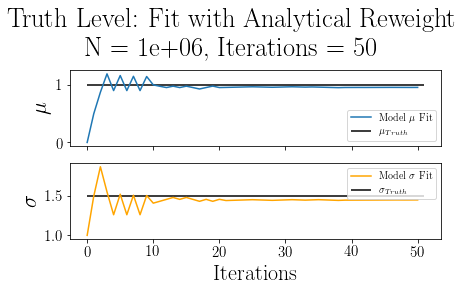

In [39]:
fit_vals = np.array(fit_vals)
fig, axs = plt.subplots(2, sharex=True, constrained_layout=True)
fig.suptitle(
    "Truth Level: Fit with Analytical Reweight\nN = {:.0e}, Iterations = {:.0f}"
    .format(N, iterations))
axs[0].plot(fit_vals[:, 0], label='Model $\mu$ Fit')
axs[0].hlines(theta1_param[0], 0, len(fit_vals), label='$\mu_{Truth}$')
axs[0].set_ylabel(r'$\mu$')
axs[0].legend(prop=fontP)

axs[1].plot(fit_vals[:, 1], label='Model $\sigma$ Fit', color='orange')
axs[1].hlines(theta1_param[1], 0, len(fit_vals), label='$\sigma_{Truth}$')
axs[1].set_ylabel(r'$\sigma$')
axs[1].legend(prop=fontP)
plt.xlabel("Iterations")
# plt.savefig(
#     "GaussianAltFit-2D-Truth-Level:Fit-with-Analytical-Reweight\nN ={:.0e}-Iterations={:.0f}.png"
#     .format(N, iterations))
plt.show()

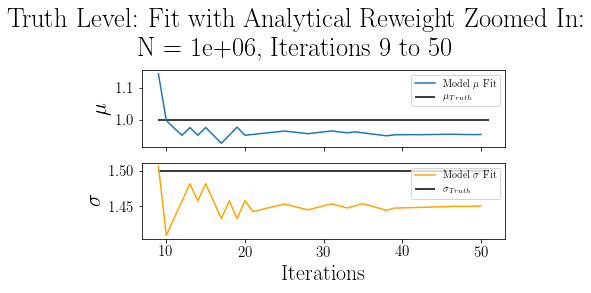

In [40]:
# Zoom into later iterations (finer fit)

fit_vals = np.array(fit_vals)
fig, axs = plt.subplots(2, sharex=True, constrained_layout=True)
fig.suptitle(
    "Truth Level: Fit with Analytical Reweight Zoomed In:\n N = {:.0e}, Iterations {:.0f} to {:.0f}"
    .format(N, index_refine[1], iterations))
axs[0].plot(np.arange(index_refine[1], len(fit_vals[:, 0])),
            fit_vals[index_refine[1]:, 0],
            label='Model $\mu$ Fit')
axs[0].hlines(theta1_param[0],
              index_refine[1],
              len(fit_vals),
              label='$\mu_{Truth}$')
axs[0].set_ylabel(r'$\mu$')
axs[0].legend(prop=fontP)

axs[1].plot(np.arange(index_refine[1], len(fit_vals[:, 1])),
            fit_vals[index_refine[1]:, 1],
            label='Model $\sigma$ Fit',
            color='orange')
axs[1].hlines(theta1_param[1],
              index_refine[1],
              len(fit_vals),
              label='$\sigma_{Truth}$')
axs[1].set_ylabel(r'$\sigma$')
axs[1].legend(prop=fontP)
plt.xlabel("Iterations")
# plt.savefig(
#     "GaussianAltFit-2D-Truth-Level:Fit-with-Analytical-Reweight-Zoomed-In:\nN={:.0e}-Iterations{:.0f}to{:.0f}.png"
#     .format(N, index_refine[1], iterations))
plt.show()

### Detector Level Gradient Fit

In [41]:
def my_loss_wrapper_fit_D(
        mysign=1,  # -1 for training theta, +1 for training g
        reweight_type='DCTR',
        loss='MSE',
        batch_size=1000):
    def my_loss(y_true, y_pred):
        y_true = tf.gather(y_true, np.arange(batch_size))
        x_T = tf.gather(y_true, [1], axis=1)  # sim truth for reweighting
        y_true = tf.gather(y_true, [0], axis=1)  # actual y_true for loss
        # Getting theta_prime:
        if mysign == 1:
            # when not training theta, fetch as np array
            theta_prime = model_fit.layers[-1].get_weights()[0]
        else:
            # when training theta, fetch as tf.Variable
            theta_prime = model_fit.trainable_weights[-1]

        if reweight_type == 'DCTR':
            # NN (DCTR) reweight
            weights = reweight(x_T, theta_prime)
        elif reweight_type == 'analytical':
            # analytical reweight
            weights = analytical_reweight(x_T, theta_prime)
        else:
            raise ValueError(
                "reweight_type must be set to 'DCTR' or 'analytical'")

        if loss == 'MSE':
            # Mean Squared Loss
            t_loss = mysign * (y_true * (y_true - y_pred)**2 + weights *
                               (1. - y_true) * (y_true - y_pred)**2)
        elif loss == 'categorical_crossentropy':
            # Categorical Cross-Entropy Loss

            # Clip the prediction value to prevent NaN's and Inf's
            epsilon = K.epsilon()
            y_pred = K.clip(y_pred, epsilon, 1. - epsilon)

            t_loss = -mysign * ((y_true) * K.log(y_pred) + weights *
                                (1 - y_true) * K.log(1 - y_pred))
        else:
            raise ValueError(
                "loss must be set to 'MSE' or 'categorical_crossentropy'")

        return K.mean(t_loss)

    return my_loss

In [42]:
# Reset parameters

fit_vals = [theta_fit_init]
model_fit.layers[-1].set_weights(np.array([theta_fit_init]))
optimizer = keras.optimizers.Adam(lr=lr_initial)
index_refine = np.array([0])

In [43]:
for iteration in range(iterations):
    print("Iteration: ", iteration + 1)

    # Reshuffling Training data
    X_train, X_test, y_train, y_test = train_test_split(xvals,
                                                        yvals,
                                                        test_size=0.5)

    #'Erasing' Truth level for data, we can't actually observe this
    X_train[:, 0][y_train == 1], X_test[:, 0][y_test == 1] = 0., 0.
    X_train_theta[:, 0][y_train_theta == 1] = 0.

    # 'hiding' truth level for simulation in model output (used in reweighting)
    X_train_D, y_train_D = X_train[:, 1], np.stack([y_train, X_train[:, 0]],
                                                   axis=1)
    X_test_D, y_test_D = X_test[:, 1], np.stack([y_test, X_test[:, 0]], axis=1)

    # fix \theta and train g
    for i in range(len(model_fit.layers) - 1):
        model_fit.layers[i].trainable = True
        pass

    model_fit.layers[-1].trainable = False
    #model.summary()

    model_fit.compile(optimizer='Adam',
                      loss=my_loss_wrapper_fit_D(
                          1,
                          loss='categorical_crossentropy',
                          batch_size=batch_size_g),
                      metrics=['accuracy'])

    print("Training g")
    model_fit.fit(np.array(X_train_D),
                  y_train_D,
                  epochs=100,
                  batch_size=batch_size_g,
                  validation_data=(np.array(X_test_D), y_test_D),
                  verbose=0,
                  callbacks=[earlystopping])

    #Now, fix g and train \theta.

    for i in range(len(model_fit.layers) - 1):
        model_fit.layers[i].trainable = False
        pass

    model_fit.layers[-1].trainable = True
    # special optimizer and batch size = 2*N
    model_fit.compile(optimizer=optimizer,
                      loss=my_loss_wrapper_fit_D(
                          -1,
                          loss='categorical_crossentropy',
                          batch_size=batch_size_theta),
                      metrics=['accuracy'])
    #     model.summary()
    print("Training theta")
    model_fit.fit(np.array(X_train_theta_D),
                  y_train_theta_D,
                  epochs=1,
                  batch_size=batch_size_theta,
                  verbose=0,
                  callbacks=callbacks)

    print("\n")

    # Detecting oscillatory behavior (oscillations around truth values)
    # Then refine fit by decreasing learning rate /10

    fit_vals_mu = np.array(fit_vals)[(index_refine[-1]):, 0]
    fit_vals_sigma = np.array(fit_vals)[(index_refine[-1]):, 1]

    # Get RECENT relative extrema, if it alternates --> oscillatory behavior
    extrema_mu = np.concatenate(
        (argrelmin(fit_vals_mu)[0], argrelmax(fit_vals_mu)[0]))
    extrema_mu = extrema_mu[extrema_mu >= iteration - index_refine[-1] - 20]

    extrema_sigma = np.concatenate(
        (argrelmin(fit_vals_sigma)[0], argrelmax(fit_vals_sigma)[0]))
    extrema_sigma = extrema_sigma[extrema_sigma >= iteration -
                                  index_refine[-1] - 20]

    if (len(extrema_mu) == 0) or (
            len(extrema_sigma)
            == 0):  # If none are found, keep fitting (catching index error)
        pass
    elif (len(extrema_mu) >= 6) and (len(extrema_sigma) >=
                                     6):  #If enough are found, refine fit
        index_refine = np.append(index_refine, iteration + 1)
        print('==============================\n' +
              '====Refining Learning Rate====\n' +
              '==============================')
        optimizer.lr = optimizer.lr / 10

        mean_fit = np.array([[
            np.mean(fit_vals_mu[len(fit_vals_mu) - 4:len(fit_vals_mu)]),
            np.mean(fit_vals_sigma[len(fit_vals_sigma) -
                                   4:len(fit_vals_sigma)])
        ]])

        model_fit.layers[-1].set_weights(mean_fit)
    pass
    pass

Iteration:  1
Training g
Training theta
Theta fit =  [0.4999856 1.4999838]


Iteration:  2
Training g
Training theta
Theta fit =  [0.8720343 1.8719933]


Iteration:  3
Training g
Training theta
Theta fit =  [1.1913209 1.5526016]


Iteration:  4
Training g
Training theta
Theta fit =  [0.90078396 1.2621198 ]


Iteration:  5
Training g
Training theta
Theta fit =  [1.173453  1.5348451]


Iteration:  6
Training g
Training theta
Theta fit =  [0.9124255 1.7958302]


Iteration:  7
Training g
Training theta
Theta fit =  [0.66002166 1.5426548 ]


Iteration:  8
Training g
Training theta
Theta fit =  [0.9078768 1.2950666]


Iteration:  9
Training g
Training theta
Theta fit =  [1.1522048 1.539429 ]


Iteration:  10
Training g
Training theta
Theta fit =  [0.9100287 1.7816043]


Iteration:  11
Training g
Training theta
Theta fit =  [1.1509993 1.5405526]


Iteration:  12
Training g
Training theta
Theta fit =  [0.9103086 1.299923 ]


Iteration:  13
Training g
Training theta
Theta fit =  [1.1512212 1.54

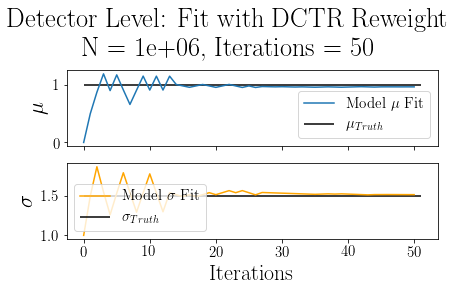

In [44]:
fit_vals = np.array(fit_vals)
fig, axs = plt.subplots(2, sharex=True, constrained_layout=True)
fig.suptitle(
    "Detector Level: Fit with DCTR Reweight\nN = {:.0e}, Iterations = {:.0f}".
    format(N, iterations))
axs[0].plot(fit_vals[:, 0], label='Model $\mu$ Fit')
axs[0].hlines(theta1_param[0], 0, len(fit_vals), label='$\mu_{Truth}$')
axs[0].set_ylabel(r'$\mu$')
axs[0].legend()

axs[1].plot(fit_vals[:, 1], label='Model $\sigma$ Fit', color='orange')
axs[1].hlines(theta1_param[1], 0, len(fit_vals), label='$\sigma_{Truth}$')
axs[1].set_ylabel(r'$\sigma$')
axs[1].legend()
plt.xlabel("Iterations")
# plt.savefig(
#     "GaussianAltFit-2D-Detector-Level:Fit-with-DCTR-Reweight\nN={:.0e}-Iterations={:.0f}.png"
#     .format(N, iterations))
plt.show()

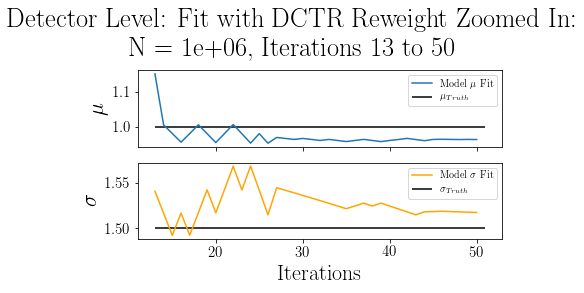

In [45]:
# Zoom into later iterations (finer fit)

fit_vals = np.array(fit_vals)
fig, axs = plt.subplots(2, sharex=True, constrained_layout=True)
fig.suptitle(
    "Detector Level: Fit with DCTR Reweight Zoomed In:\n N = {:.0e}, Iterations {:.0f} to {:.0f}"
    .format(N, index_refine[1], iterations))
axs[0].plot(np.arange(index_refine[1], len(fit_vals[:, 0])),
            fit_vals[index_refine[1]:, 0],
            label='Model $\mu$ Fit')
axs[0].hlines(theta1_param[0],
              index_refine[1],
              len(fit_vals),
              label='$\mu_{Truth}$')
axs[0].set_ylabel(r'$\mu$')
axs[0].legend(prop=fontP)

axs[1].plot(np.arange(index_refine[1], len(fit_vals[:, 1])),
            fit_vals[index_refine[1]:, 1],
            label='Model $\sigma$ Fit',
            color='orange')
axs[1].hlines(theta1_param[1],
              index_refine[1],
              len(fit_vals),
              label='$\sigma_{Truth}$')
axs[1].set_ylabel(r'$\sigma$')
axs[1].legend(prop=fontP)
plt.xlabel("Iterations")
# plt.savefig(
#     "GaussianAltFit-2D-Detector-Level:Fit-with-DCTR-Reweight-Zoomed In:\nN ={:.0e}-Iterations-{:.0f}to{:.0f}.png"
#     .format(N, index_refine[1], iterations))
plt.show()

#### Compare Fitting between DCTR Reweighting and Analytical Reweighting

In [46]:
# Reset parameters

fit_vals = [theta_fit_init]
model_fit.layers[-1].set_weights(np.array([theta_fit_init]))
optimizer = keras.optimizers.Adam(lr=lr_initial)
index_refine = np.array([0])

In [47]:
for iteration in range(iterations):
    print("Iteration: ", iteration + 1)

    # Reshuffling Training data
    X_train, X_test, y_train, y_test = train_test_split(xvals,
                                                        yvals,
                                                        test_size=0.5)

    #'Erasing' Truth level for data, we can't actually observe this
    X_train[:, 0][y_train == 1], X_test[:, 0][y_test == 1] = 0., 0.
    X_train_theta[:, 0][y_train_theta == 1] = 0.

    # 'hiding' truth level for simulation in model output (used in reweighting)
    X_train_D, y_train_D = X_train[:, 1], np.stack([y_train, X_train[:, 0]],
                                                   axis=1)
    X_test_D, y_test_D = X_test[:, 1], np.stack([y_test, X_test[:, 0]], axis=1)

    # fix \theta and train g
    for i in range(len(model_fit.layers) - 1):
        model_fit.layers[i].trainable = True
        pass

    model_fit.layers[-1].trainable = False
    #model.summary()

    model_fit.compile(optimizer='Adam',
                      loss=my_loss_wrapper_fit_D(
                          1,
                          reweight_type='analytical',
                          loss='categorical_crossentropy',
                          batch_size=batch_size_g),
                      metrics=['accuracy'])

    print("Training g")
    model_fit.fit(np.array(X_train_D),
                  y_train_D,
                  epochs=100,
                  batch_size=batch_size_g,
                  validation_data=(np.array(X_test_D), y_test_D),
                  verbose=0,
                  callbacks=[earlystopping])

    #Now, fix g and train \theta.

    for i in range(len(model_fit.layers) - 1):
        model_fit.layers[i].trainable = False
        pass

    model_fit.layers[-1].trainable = True
    # special optimizer and batch size = 2*N
    model_fit.compile(optimizer=optimizer,
                      loss=my_loss_wrapper_fit_D(
                          -1,
                          reweight_type='analytical',
                          loss='categorical_crossentropy',
                          batch_size=batch_size_theta),
                      metrics=['accuracy'])
    #     model.summary()
    print("Training theta")
    model_fit.fit(np.array(X_train_theta_D),
                  y_train_theta_D,
                  epochs=1,
                  batch_size=batch_size_theta,
                  verbose=0,
                  callbacks=callbacks)

    print("\n")

    # Detecting oscillatory behavior (oscillations around truth values)
    # Then refine fit by decreasing learning rate /10

    fit_vals_mu = np.array(fit_vals)[(index_refine[-1]):, 0]
    fit_vals_sigma = np.array(fit_vals)[(index_refine[-1]):, 1]

    # Get RECENT relative extrema, if it alternates --> oscillatory behavior
    extrema_mu = np.concatenate(
        (argrelmin(fit_vals_mu)[0], argrelmax(fit_vals_mu)[0]))
    extrema_mu = extrema_mu[extrema_mu >= iteration - index_refine[-1] - 20]

    extrema_sigma = np.concatenate(
        (argrelmin(fit_vals_sigma)[0], argrelmax(fit_vals_sigma)[0]))
    extrema_sigma = extrema_sigma[extrema_sigma >= iteration -
                                  index_refine[-1] - 20]

    if (len(extrema_mu) == 0) or (
            len(extrema_sigma)
            == 0):  # If none are found, keep fitting (catching index error)
        pass
    elif (len(extrema_mu) >= 6) and (len(extrema_sigma) >=
                                     6):  #If enough are found, refine fit
        index_refine = np.append(index_refine, iteration + 1)
        print('==============================\n' +
              '====Refining Learning Rate====\n' +
              '==============================')
        optimizer.lr = optimizer.lr / 10

        mean_fit = np.array([[
            np.mean(fit_vals_mu[len(fit_vals_mu) - 4:len(fit_vals_mu)]),
            np.mean(fit_vals_sigma[len(fit_vals_sigma) -
                                   4:len(fit_vals_sigma)])
        ]])

        model_fit.layers[-1].set_weights(mean_fit)
    pass
    pass

Iteration:  1
Training g
Training theta
Theta fit =  [0.37205634 1.3720574 ]


Iteration:  2
Training g
Training theta
Theta fit =  [0.7441054 1.7440878]


Iteration:  3
Training g
Training theta
Theta fit =  [1.0634707 1.4247229]


Iteration:  4
Training g
Training theta
Theta fit =  [0.77306414 1.7133325 ]


Iteration:  5
Training g
Training theta
Theta fit =  [1.0457672 1.4406228]


Iteration:  6
Training g
Training theta
Theta fit =  [0.78494227 1.7015435 ]


Iteration:  7
Training g
Training theta
Theta fit =  [1.0380807 1.4483826]


Iteration:  8
Training g
Training theta
Theta fit =  [1.285907 1.696243]


Iteration:  9
Training g
Training theta
Theta fit =  [1.0415592 1.4518949]


Iteration:  10
Training g
Training theta
Theta fit =  [0.79947335 1.2098567 ]


Iteration:  11
Training g
Training theta
Theta fit =  [1.0404952 1.4509094]


====Refining Learning Rate====
Iteration:  12
Training g
Training theta
Theta fit =  [1.0177976 1.476247 ]


Iteration:  13
Training g
Training t

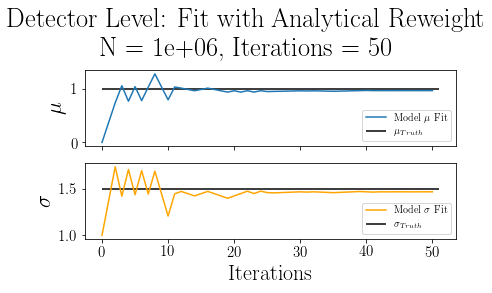

In [48]:
fit_vals = np.array(fit_vals)
fig, axs = plt.subplots(2, sharex=True, constrained_layout=True)
fig.suptitle(
    "Detector Level: Fit with Analytical Reweight\nN = {:.0e}, Iterations = {:.0f}"
    .format(N, iterations))
axs[0].plot(fit_vals[:, 0], label='Model $\mu$ Fit')
axs[0].hlines(theta1_param[0], 0, len(fit_vals), label='$\mu_{Truth}$')
axs[0].set_ylabel(r'$\mu$')
axs[0].legend(prop=fontP)

axs[1].plot(fit_vals[:, 1], label='Model $\sigma$ Fit', color='orange')
axs[1].hlines(theta1_param[1], 0, len(fit_vals), label='$\sigma_{Truth}$')
axs[1].set_ylabel(r'$\sigma$')
axs[1].legend(prop=fontP)
plt.xlabel("Iterations")
# plt.savefig(
#     "GaussianAltFit-2D-Detector-Level:Fit-with-Analytical-Reweight\nN={:.0e}-Iterations={:.0f}.png"
#     .format(N, iterations))
plt.show()

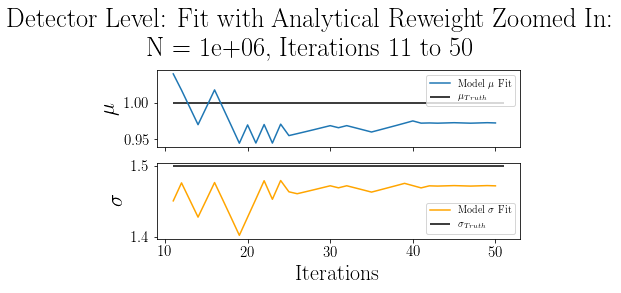

In [49]:
# Zoom into later iterations (finer fit)

fit_vals = np.array(fit_vals)
fig, axs = plt.subplots(2, sharex=True, constrained_layout=True)
fig.suptitle(
    "Detector Level: Fit with Analytical Reweight Zoomed In:\n N = {:.0e}, Iterations {:.0f} to {:.0f}"
    .format(N, index_refine[1], iterations))
axs[0].plot(np.arange(index_refine[1], len(fit_vals[:, 0])),
            fit_vals[index_refine[1]:, 0],
            label='Model $\mu$ Fit')
axs[0].hlines(theta1_param[0],
              index_refine[1],
              len(fit_vals),
              label='$\mu_{Truth}$')
axs[0].set_ylabel(r'$\mu$')
axs[0].legend(prop=fontP)

axs[1].plot(np.arange(index_refine[1], len(fit_vals[:, 1])),
            fit_vals[index_refine[1]:, 1],
            label='Model $\sigma$ Fit',
            color='orange')
axs[1].hlines(theta1_param[1],
              index_refine[1],
              len(fit_vals),
              label='$\sigma_{Truth}$')
axs[1].set_ylabel(r'$\sigma$')
axs[1].legend(prop=fontP)
plt.xlabel("Iterations")
# plt.savefig(
#     "GaussianAltFit-2D-Detector-Level:Fit-with-Analytical-Reweight-Zoomed-In:\nN={:.0e},Iterations{:.0f}to{:.0f}.png"
#     .format(N, index_refine[1], iterations))
plt.show()